In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import imagenet_utils
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model

In [ ]:
def residual_block(inputs, filters, strides=1):
    identity = inputs

    x = layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Residual connection
    if strides != 1 or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x

In [ ]:
input_shape = (256,256,3)
num_classes = 2
def build_rest(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    # Entry flow
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    # Middle flow (stack residual blocks)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Exit flow
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
# Define the input shape and number of classes
input_shape = (256, 256, 3)  # Adjust based on your image size and channels
num_classes = 2  # Define the number of disease classes in your dataset


In [ ]:
# Build the ResT model
rest_model = build_rest(input_shape, num_classes)

# Compile the model
rest_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Directory paths for train, validation, and test sets
train_dir="/content/drive/MyDrive/dataset2/dataset2/train"
valid_dir="/content/drive/MyDrive/dataset2/dataset2/valid"
test_dir="/content/drive/MyDrive/dataset2/dataset2/test"


In [ ]:
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Normalization for validation and test data
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


In [ ]:
# Normalization for validation and test data
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


In [ ]:
# Generate data iterators using ImageDataGenerator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'  # Use 'sparse' for sparse categorical labels
)

val_gen = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)

test_gen = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)

Found 1798 images belonging to 2 classes.
Found 495 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


In [ ]:
# Set up callbacks (early stopping and model checkpoint)
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)
mc = ModelCheckpoint(filepath="best_model.h5", monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1, save_best_only=True)

callbacks = [es, mc]

In [ ]:
# Train the model
history = rest_model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks,
    validation_steps=16,
    steps_per_epoch=16
)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 1.2877 - accuracy: 0.5605
Epoch 1: val_accuracy improved from -inf to 0.39596, saving model to best_model.h5
16/16 [==============================] - 310s 20s/step - loss: 1.2877 - accuracy: 0.5605 - val_loss: 1.2605 - val_accuracy: 0.3960


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.5865 - accuracy: 0.7428
Epoch 2: val_accuracy improved from 0.39596 to 0.42222, saving model to best_model.h5
16/16 [==============================] - 133s 8s/step - loss: 0.5865 - accuracy: 0.7428 - val_loss: 0.7036 - val_accuracy: 0.4222
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.5483 - accuracy: 0.7520
Epoch 3: val_accuracy did not improve from 0.42222
16/16 [==============================] - 158s 10s/step - loss: 0.5483 - accuracy: 0.7520 - val_loss: 1.0564 - val_accuracy: 0.4121
Epoch 4/10
16/16 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.7551
Epoch 4: val_accuracy improved from 0.42222 to 0.44848, saving model to best_model.h5
16/16 [==============================] - 144s 9s/step - loss: 0.5024 - accuracy: 0.7551 - val_loss: 0.8396 - val_accuracy: 0.4485
Epoch 5/10
16/16 [==============================] - ETA: 0s - loss: 0.5327 - accuracy: 0.7402
Epoch 5: v

In [ ]:
# Evaluate the model
batch_size=32
test_steps = test_gen.samples // batch_size + 1
predictions = rest_model.predict(test_gen, steps=test_steps)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

16/16 [==============================] - 35s 2s/step


In [ ]:
from sklearn.metrics import f1_score
# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='macro')
# Print F1 score
print("F1 Score:", f1)

F1 Score: 0.45144168053618816


In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[123  72]
 [199 101]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Define class names based on your dataset
class_names = ['Melanoma Skin Cancer Nevi and Moles', 'Tinea Ringworm Candidiasis and other Fungal Infections']

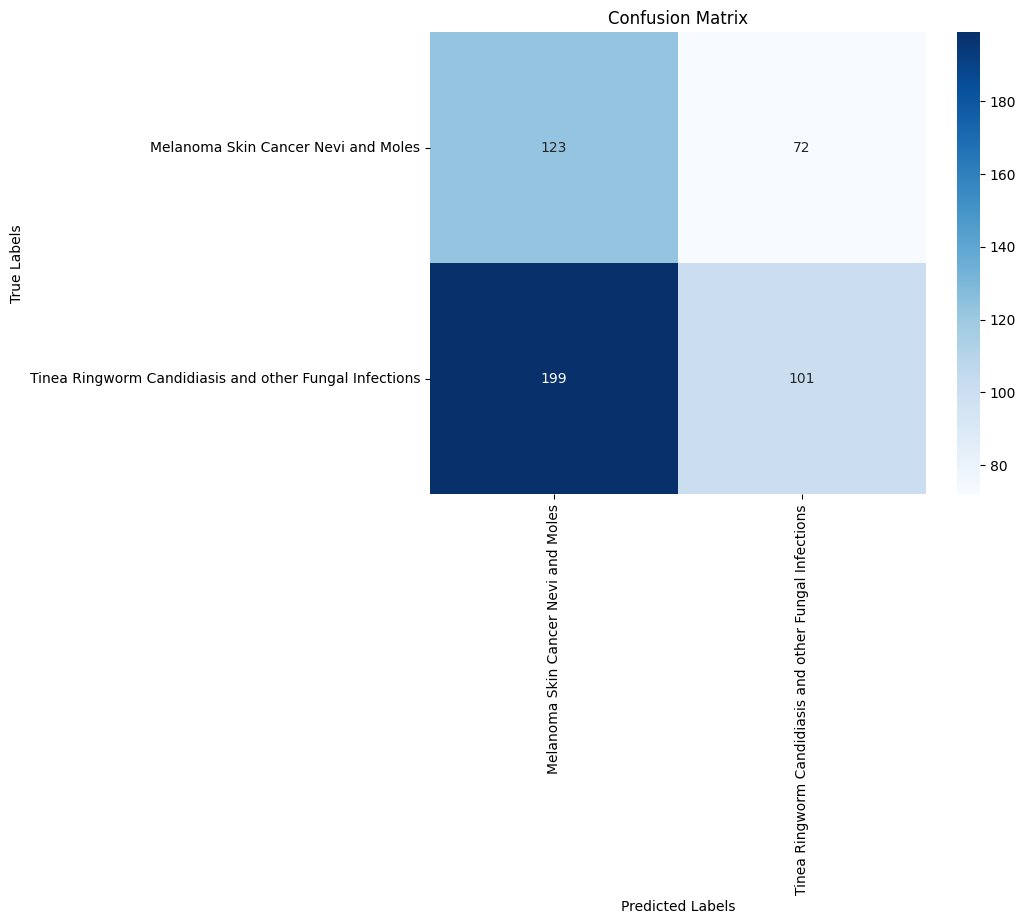

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
# Print classification report
print("Classification Report:")
print(report)

Classification Report:
                                                        precision    recall  f1-score   support

                   Melanoma Skin Cancer Nevi and Moles       0.38      0.63      0.48       195
Tinea Ringworm Candidiasis and other Fungal Infections       0.58      0.34      0.43       300

                                              accuracy                           0.45       495
                                             macro avg       0.48      0.48      0.45       495
                                          weighted avg       0.50      0.45      0.45       495



In [ ]:
# Assuming you have trained the model using the code snippet provided
# You can access the final training and validation accuracy from the history object

# Get the final training and validation accuracy
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

# Print the final training and validation accuracy
print("Final Training Accuracy:", final_training_accuracy)
print("Final Validation Accuracy:", final_validation_accuracy)


Final Training Accuracy: 0.755859375
Final Validation Accuracy: 0.7353535294532776


In [ ]:
from sklearn.metrics import accuracy_score

# Compute testing accuracy
Testing_accuracy = accuracy_score(y_true, y_pred)

# Print Testing accuracy
print(" Testing Accuracy:", Testing_accuracy)


 Testing Accuracy: 0.45252525252525255


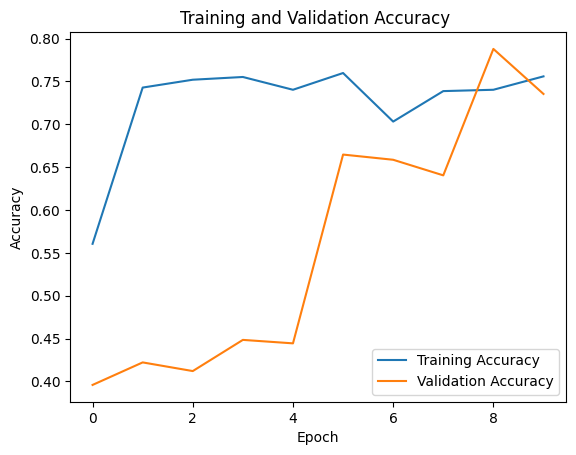

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

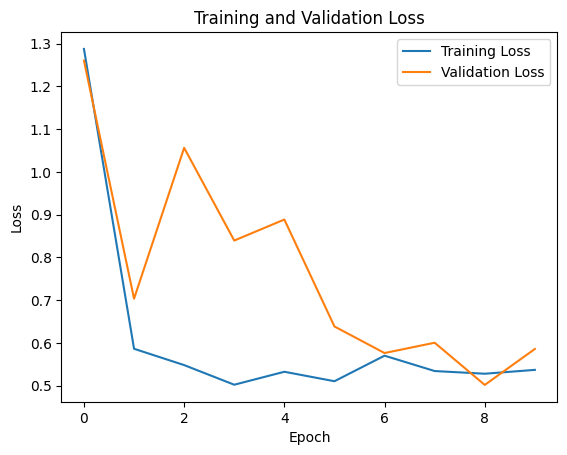

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nWeighted F1 Score:", f1)


Weighted F1 Score: 0.44627008695201753


In [ ]:
# Feature extraction: Freeze all layers except the last few for fine-tuning
for layer in rest_model.layers[:-10]:
    layer.trainable = False

In [ ]:
# Fine-tuning: Allow the last few layers of the ResNet50 model to be trainable
for layer in rest_model.layers[:-10]:
    layer.trainable = True

In [ ]:
# Train the model
history = rest_model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks,
    validation_steps=16,
    steps_per_epoch=16
)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.7539
Epoch 1: val_accuracy did not improve from 0.78788
16/16 [==============================] - 158s 10s/step - loss: 0.5453 - accuracy: 0.7539 - val_loss: 0.7681 - val_accuracy: 0.4848
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.5401 - accuracy: 0.7572
Epoch 2: val_accuracy did not improve from 0.78788
16/16 [==============================] - 144s 9s/step - loss: 0.5401 - accuracy: 0.7572 - val_loss: 0.5584 - val_accuracy: 0.7293
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.5431 - accuracy: 0.7227
Epoch 3: val_accuracy did not improve from 0.78788
16/16 [==============================] - 146s 9s/step - loss: 0.5431 - accuracy: 0.7227 - val_loss: 0.5633 - val_accuracy: 0.7232
Epoch 4/10
16/16 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.7461
Epoch 4: val_accuracy did not improve from 0.78788
16/16 [======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 6/10
16/16 [==============================] - ETA: 0s - loss: 0.5307 - accuracy: 0.7551
Epoch 6: val_accuracy did not improve from 0.78990
16/16 [==============================] - 143s 9s/step - loss: 0.5307 - accuracy: 0.7551 - val_loss: 0.6599 - val_accuracy: 0.6263
Epoch 7/10
16/16 [==============================] - ETA: 0s - loss: 0.5197 - accuracy: 0.7490
Epoch 7: val_accuracy did not improve from 0.78990
16/16 [==============================] - 134s 8s/step - loss: 0.5197 - accuracy: 0.7490 - val_loss: 0.7845 - val_accuracy: 0.4808
Epoch 8/10
16/16 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.7637
Epoch 8: val_accuracy did not improve from 0.78990
16/16 [==============================] - 153s 10s/step - loss: 0.4937 - accuracy: 0.7637 - val_loss: 0.5350 - val_accuracy: 0.7778
Epoch 8: early stopping


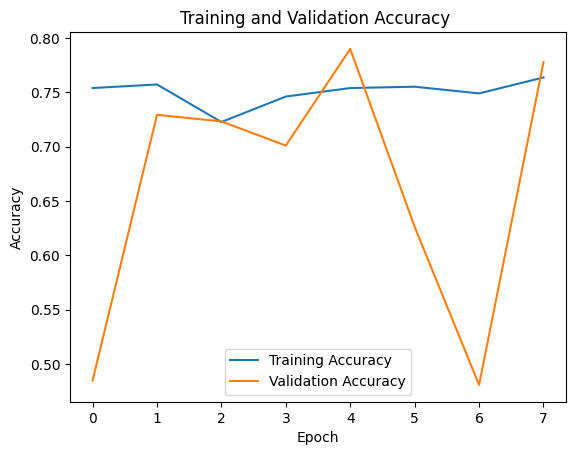

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

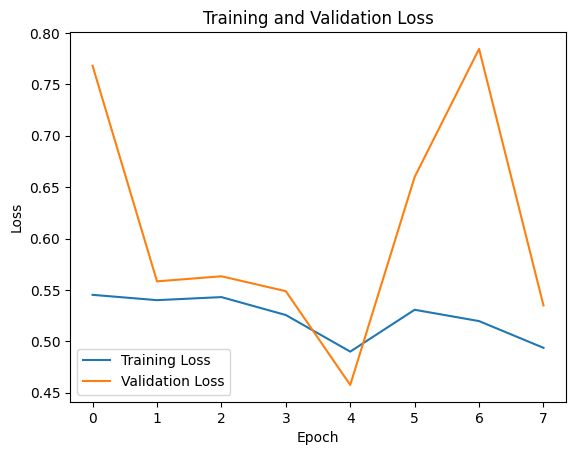

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
batch_size=32
test_steps = test_gen.samples // batch_size + 1
predictions = rest_model.predict(test_gen, steps=test_steps)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

16/16 [==============================] - 34s 2s/step


In [ ]:
from sklearn.metrics import f1_score
# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='macro')
# Print F1 score
print("F1 Score:", f1)

F1 Score: 0.49794456611496063


In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 60 135]
 [ 91 209]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Define class names based on your dataset
class_names = ['Melanoma Skin Cancer Nevi and Moles', 'Tinea Ringworm Candidiasis and other Fungal Infections']

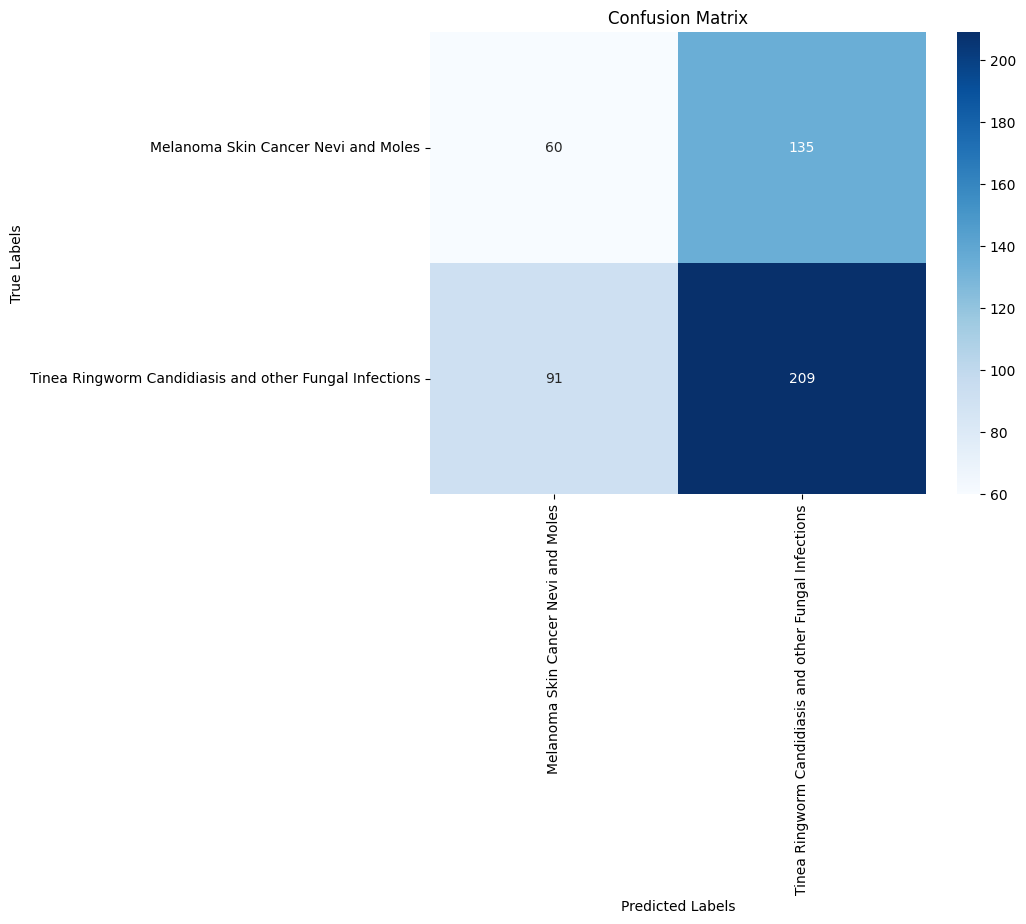

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
# Print classification report
print("Classification Report:")
print(report)

Classification Report:
                                                        precision    recall  f1-score   support

                   Melanoma Skin Cancer Nevi and Moles       0.40      0.31      0.35       195
Tinea Ringworm Candidiasis and other Fungal Infections       0.61      0.70      0.65       300

                                              accuracy                           0.54       495
                                             macro avg       0.50      0.50      0.50       495
                                          weighted avg       0.52      0.54      0.53       495



In [ ]:
# Assuming you have trained the model using the code snippet provided
# You can access the final training and validation accuracy from the history object

# Get the final training and validation accuracy
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

# Print the final training and validation accuracy
print("Final Training Accuracy:", final_training_accuracy)
print("Final Validation Accuracy:", final_validation_accuracy)


Final Training Accuracy: 0.763671875
Final Validation Accuracy: 0.7777777910232544


In [ ]:
from sklearn.metrics import accuracy_score

# Compute testing accuracy
Testing_accuracy = accuracy_score(y_true, y_pred)

# Print Testing accuracy
print(" Testing Accuracy:", Testing_accuracy)


 Testing Accuracy: 0.5434343434343434


In [ ]:
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nWeighted F1 Score:", f1)


Weighted F1 Score: 0.530001120601774
